In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from skimage.restoration import denoise_wavelet
from time import time as ti

In [4]:
TIME_STEPS = 1200
Skips = 100

In [5]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

def split_list_by_ones(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    if len(values) > time_steps:
        for i in range(int((len(values) - time_steps + skips)/skips)):
            output.append(values[i*skips : (i*skips + time_steps)])
        return np.stack(output)

In [6]:
def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

In [7]:
start=ti()

In [42]:
DataFolder = '/scratch/Recordings2/'
files=['230704 recording4.csv',
       '230421 recording1.csv',
       '230420 recording2.csv',
       ]
file = files[2]

In [43]:
dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')

print("File Read", ti()-start)

File Read 1977.9748673439026


In [44]:
dataset = dataset.rename(columns={0:"Day"})
dataset = dataset.rename(columns={1:"Second"})
dataset = dataset.rename(columns={2:"FracSec"})
dataset = dataset.rename(columns={3:"p"})
dataset = dataset.rename(columns={4:"h"})
dataset = dataset.rename(columns={5:"v"})
dataset = dataset.rename(columns={6:"Sensor"})

#dataset['Second'].replace('',0)
#dataset['FracSec'].replace('',0)
#dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)

#dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
#dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

#dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
#dataset["timestamps"] = dataset["timestamp"]

In [45]:
dataset

,Day,Second,FracSec,p,h,v,Sensor
0,230420,0,2130,-0.01679,-0.00193,-1.01469,2
1,230420,0,2196,-0.01020,-0.00071,-0.98149,2
2,230420,0,2261,0.02299,0.01051,-0.97197,2
3,230420,0,2326,0.02324,0.03395,-0.98173,2
4,230420,0,2392,-0.00874,0.01833,-0.98100,2
...,...,...,...,...,...,...,...
13226065,230420,235959,9753,0.00395,-0.00803,-0.99882,2
13226066,230420,235959,9818,0.01176,-0.00583,-0.98906,2
13226067,230420,235959,9883,0.00615,-0.01389,-1.01445,2
13226068,230420,235959,9949,-0.00166,0.00197,-0.99541,2


In [46]:
dataset["p"] = dataset.p - np.average(dataset.p)
dataset["h"] = dataset.h - np.average(dataset.h)
dataset["v"] = dataset.v - np.average(dataset.v)
#dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

#dataset.index = dataset.timestamp

In [47]:
dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
#dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

print("Data Cleaned", ti()-start, len(dataset.p))

Data Cleaned 1982.1635258197784 13226070


In [48]:
RawData = dataset.v
SmoothData = dataset.SmoothV
RollSize = 25

Diffs = RawData - SmoothData

Sqs = Diffs * Diffs

Sqs = Sqs.tolist() 

Sqs.extend(np.zeros(RollSize))

mSqs = np.matrix(Sqs)

for i in range(RollSize):
    Sqs.insert(0, Sqs.pop())
    mSqs = np.concatenate((np.matrix(Sqs),mSqs))

sVect = mSqs.sum(axis=0)
eVect = (mSqs!=0).sum(axis=0)

VarVect = sVect / eVect

StdDevs = np.sqrt(VarVect)

StdDevsZ = np.asarray(StdDevs)

StdDevsZ=np.append(StdDevsZ,[0])

StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

Size StdDevsZ 2017.8613872528076 (13226070,)


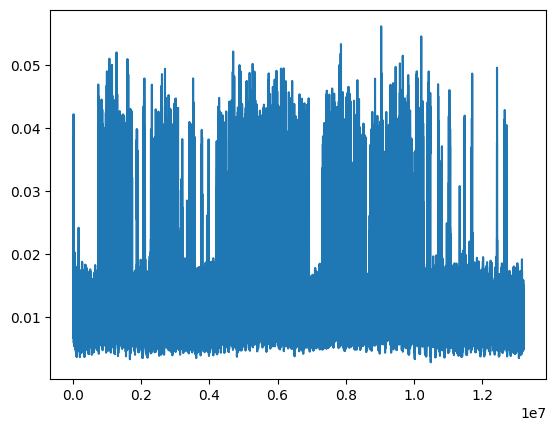

In [49]:
fig=plt.figure()
plt.plot(StdDevsZ)
plt.show()

In [50]:
StdDevsZ = np.nan_to_num(StdDevsZ)

StdDevsZ[StdDevsZ == np.inf] = 0
StdDevsZ[StdDevsZ == -np.inf] = 0

SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

print("denoise 1", ti()-start, np.shape(StdDevsZ))

denoise 1 2020.5087060928345 (13226070,)


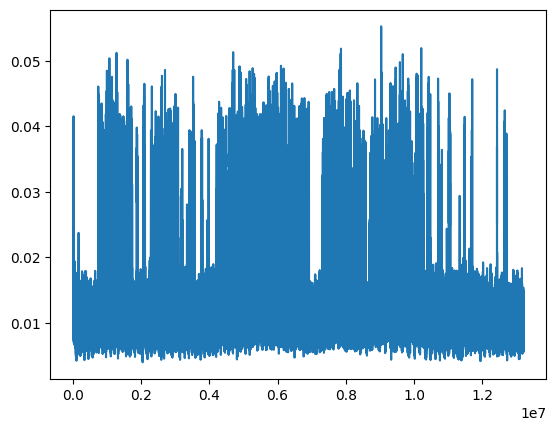

In [51]:
fig=plt.figure()
plt.plot(SmoothDevZ)
plt.show()

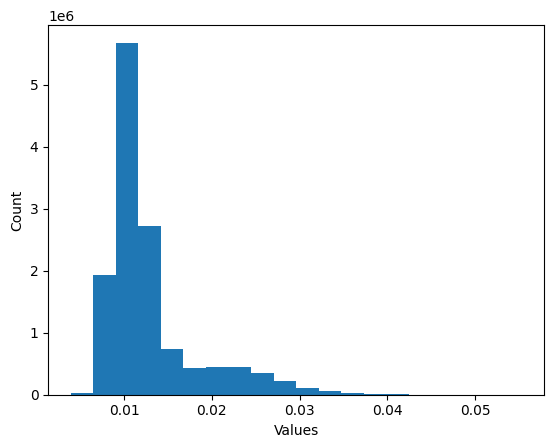

In [52]:
plt.hist(SmoothDevZ, bins=20)
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

In [53]:
SmoothDevZ[np.isnan(SmoothDevZ)]=0

Max = np.max(SmoothDevZ)

buckets = int(Max / 0.005) + 1
bins = np.linspace(0,buckets*0.005,buckets+1)
counts, bins = np.histogram(SmoothDevZ,bins=bins)

CummCount = 0
HalfWay = 0
for i in range(len(counts)):
    CummCount += counts[i]
    if CummCount / len(SmoothDevZ) >= 0.5:
        if HalfWay == 0:
            HalfWay = i

SquelchLevel = bins[HalfWay] 

print("SmoothDevz size", np.shape(SmoothDevZ),SquelchLevel)

SmoothDevz size (13226070,) 0.01


In [54]:
dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 2000, 0.02, False)

print("Squelch Made", ti()-start)

Squelch Made 2136.8847711086273


In [55]:
velocity = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)

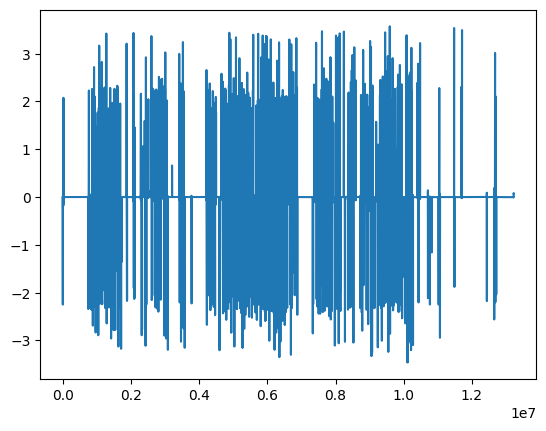

In [56]:
fig=plt.figure()
plt.plot(velocity)
plt.show()

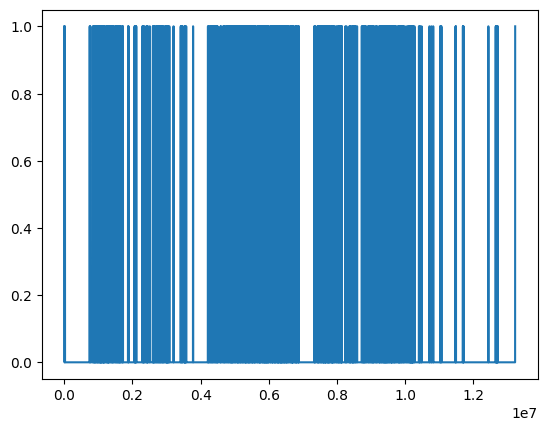

In [57]:
fig=plt.figure()
plt.plot(dataset.IsMoving)
plt.show()

In [58]:
df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)

In [59]:
df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)

In [60]:
le=[]
for i in range(len(df_pr)):
    le.append(len(df_pr[i]))
print(np.min(le), np.max(le), np.average(le))

3 8480 4283.229381443299


In [61]:
SmoothMove = []
for i in range(len(df_pr)):
    if len(df_pr[i])>TIME_STEPS:
        tempP=create_sequences(df_pr[i])
        tempH=create_sequences(df_hr[i])
        tempV=create_sequences(df_vr[i])
        for j in range(len(tempP)):
            SmoothMove.append(np.vstack((tempP[j],tempH[j],tempV[j]))) #,df_rs[i])))

In [62]:
SmoothStop = []
for i in range(len(df_ps)):
    if len(df_ps[i])>TIME_STEPS:
        tempP=create_sequences(df_ps[i])
        tempH=create_sequences(df_hs[i])
        tempV=create_sequences(df_vs[i])
        for j in range(len(tempP)):
            SmoothStop.append(np.vstack((tempP[j],tempH[j],tempV[j]))) #,df_rs[i])))

In [63]:
len(SmoothMove) #17600

12368

In [64]:
len(SmoothStop) #161000

111242